#Libraries

In [5]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

#Utility Function

In [6]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df

def agg_numeric(df, key, prefix):
    if key not in df.columns:
        raise KeyError(f"{key} not found in DataFrame. Available: {df.columns[:10].tolist()} ...")
    num_df = df.select_dtypes(include=[np.number]).copy()
    num_df[key] = df[key]
    agg = num_df.groupby(key).agg(['mean', 'max', 'min', 'sum', 'var'])
    agg.columns = [prefix + '_' + '_'.join(col).upper() for col in agg.columns]
    return agg.reset_index()


#Load Dataset

In [7]:
print("Loading datasets...")
train = reduce_mem_usage(pd.read_csv("application_train.csv"))
test = reduce_mem_usage(pd.read_csv("application_test.csv"))
bureau = reduce_mem_usage(pd.read_csv("bureau.csv"))
bureau_balance = reduce_mem_usage(pd.read_csv("bureau_balance.csv"))

# Previous Application
expected_cols_prev = [
    "SK_ID_PREV","SK_ID_CURR","NAME_CONTRACT_TYPE","AMT_ANNUITY","AMT_APPLICATION",
    "AMT_CREDIT","AMT_DOWN_PAYMENT","AMT_GOODS_PRICE","WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START","FLAG_LAST_APPL_PER_CONTRACT","NFLAG_LAST_APPL_IN_DAY",
    "RATE_DOWN_PAYMENT","RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED",
    "NAME_CASH_LOAN_PURPOSE","NAME_CONTRACT_STATUS","DAYS_DECISION","NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON","NAME_TYPE_SUITE","NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY",
    "NAME_PORTFOLIO","NAME_PRODUCT_TYPE","CHANNEL_TYPE","SELLERPLACE_AREA",
    "NAME_SELLER_INDUSTRY","CNT_PAYMENT","NAME_YIELD_GROUP","PRODUCT_COMBINATION",
    "DAYS_FIRST_DRAWING","DAYS_FIRST_DUE","DAYS_LAST_DUE_1ST_VERSION","DAYS_LAST_DUE",
    "DAYS_TERMINATION","NFLAG_INSURED_ON_APPROVAL"
]
previous = pd.read_csv("previous_application.csv", header=0)
if "SK_ID_CURR" not in previous.columns:
    previous = pd.read_csv("previous_application.csv", names=expected_cols_prev, header=0)
previous = reduce_mem_usage(previous)

# Installments
expected_cols_installments = [
    "SK_ID_PREV","SK_ID_CURR","NUM_INSTALMENT_VERSION","NUM_INSTALMENT_NUMBER",
    "DAYS_INSTALMENT","DAYS_ENTRY_PAYMENT","AMT_INSTALMENT","AMT_PAYMENT"
]
installments = pd.read_csv("installments_payments.csv", header=0)
if "SK_ID_CURR" not in installments.columns:
    installments = pd.read_csv("installments_payments.csv", names=expected_cols_installments, header=0)
installments = reduce_mem_usage(installments)

# POS Cash
expected_cols_pos = ["SK_ID_PREV","SK_ID_CURR","MONTHS_BALANCE","CNT_INSTALMENT","CNT_INSTALMENT_FUTURE","NAME_CONTRACT_STATUS","SK_DPD","SK_DPD_DEF"]
pos = pd.read_csv("POS_CASH_balance.csv", header=0)
if "SK_ID_CURR" not in pos.columns:
    pos = pd.read_csv("POS_CASH_balance.csv", names=expected_cols_pos, header=0)
pos = reduce_mem_usage(pos)

# Credit Card Balance
expected_cols_cc = ["SK_ID_PREV","SK_ID_CURR","MONTHS_BALANCE","AMT_BALANCE","AMT_CREDIT_LIMIT_ACTUAL",
                    "AMT_DRAWINGS_ATM_CURRENT","AMT_DRAWINGS_CURRENT","AMT_DRAWINGS_OTHER_CURRENT",
                    "AMT_DRAWINGS_POS_CURRENT","AMT_INST_MIN_REGULARITY","AMT_PAYMENT_CURRENT",
                    "AMT_PAYMENT_TOTAL_CURRENT","AMT_RECEIVABLE_PRINCIPAL","AMT_RECIVABLE",
                    "AMT_TOTAL_RECEIVABLE","CNT_DRAWINGS_ATM_CURRENT","CNT_DRAWINGS_CURRENT",
                    "CNT_DRAWINGS_OTHER_CURRENT","CNT_DRAWINGS_POS_CURRENT","CNT_INSTALMENT_MATURE_CUM",
                    "NAME_CONTRACT_STATUS","SK_DPD","SK_DPD_DEF"]
cc = pd.read_csv("credit_card_balance.csv", header=0)
if "SK_ID_CURR" not in cc.columns:
    cc = pd.read_csv("credit_card_balance.csv", names=expected_cols_cc, header=0)
cc = reduce_mem_usage(cc)



Loading datasets...


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:


Mem. usage decreased to 92.38 Mb (67.7% reduction)


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:


Mem. usage decreased to 14.60 Mb (67.6% reduction)


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:


Mem. usage decreased to 112.95 Mb (49.3% reduction)
Mem. usage decreased to 13.00 Mb (45.8% reduction)


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overfl

Mem. usage decreased to 194.00 Mb (34.5% reduction)


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:


Mem. usage decreased to 267.78 Mb (62.5% reduction)
Mem. usage decreased to 238.45 Mb (60.9% reduction)


/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
/tmp/ipython-input-155251515.py:18: RuntimeWarning: overfl

Mem. usage decreased to 289.33 Mb (57.1% reduction)


#Aggregation

In [8]:
bb_agg = bureau_balance.groupby("SK_ID_BUREAU").STATUS.value_counts(normalize=True).unstack(fill_value=0)
bb_agg = bb_agg.add_prefix("BB_STATUS_").reset_index()
bureau = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")
bureau_agg = agg_numeric(bureau, "SK_ID_CURR", "BUREAU")
prev_agg = agg_numeric(previous, "SK_ID_CURR", "PREV")
inst_agg = agg_numeric(installments, "SK_ID_CURR", "INST")
pos_agg = agg_numeric(pos, "SK_ID_CURR", "POS")
cc_agg = agg_numeric(cc, "SK_ID_CURR", "CC")

# =====================================================
# Merge all features
# =====================================================
for df_agg in [bureau_agg, prev_agg, inst_agg, pos_agg, cc_agg]:
    train = train.merge(df_agg, on="SK_ID_CURR", how="left")
    test = test.merge(df_agg, on="SK_ID_CURR", how="left")

#Exploratory Data Analysis (EDA)


===== EDA: Missing Values =====
PREV_RATE_INTEREST_PRIMARY_VAR        307447
PREV_RATE_INTEREST_PRIVILEGED_VAR     307447
PREV_RATE_INTEREST_PRIVILEGED_MEAN    304598
PREV_RATE_INTEREST_PRIVILEGED_MIN     304598
PREV_RATE_INTEREST_PRIMARY_MAX        304598
PREV_RATE_INTEREST_PRIVILEGED_MAX     304598
PREV_RATE_INTEREST_PRIMARY_MEAN       304598
PREV_RATE_INTEREST_PRIMARY_MIN        304598
BUREAU_BB_STATUS_1_VAR                304502
BUREAU_BB_STATUS_2_VAR                304502
dtype: int64

===== Distribusi Target =====
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


/tmp/ipython-input-670025687.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="TARGET", data=train, palette="Set2")


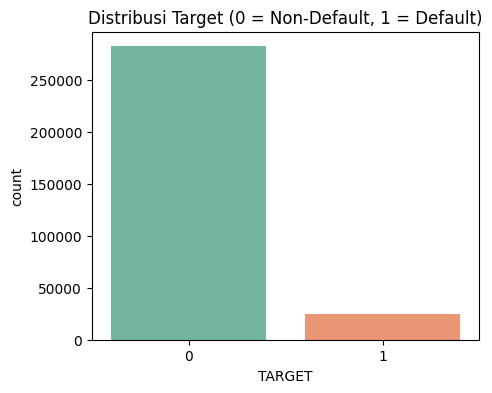


===== Korelasi Fitur dengan TARGET =====
TARGET                              1.000000
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.107692
CC_CNT_DRAWINGS_CURRENT_MAX         0.101389
BUREAU_DAYS_CREDIT_MEAN             0.089729
CC_AMT_BALANCE_MEAN                 0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN        0.086490
CC_AMT_RECIVABLE_MEAN               0.086478
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN    0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN        0.082520
DAYS_BIRTH                          0.078239
Name: TARGET, dtype: float64


In [9]:
print("\n===== EDA: Missing Values =====")
print(train.isnull().sum().sort_values(ascending=False).head(10))

print("\n===== Distribusi Target =====")
print(train["TARGET"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x="TARGET", data=train, palette="Set2")
plt.title("Distribusi Target (0 = Non-Default, 1 = Default)")
plt.show()

# Korelasi fitur numerik dengan target
corr = train.corr(numeric_only=True)["TARGET"].sort_values(ascending=False)
print("\n===== Korelasi Fitur dengan TARGET =====")
print(corr.head(10))


#Preprocessing Data

In [10]:

#Encode categorical features
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    full_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(full_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))


# Prepare features & handle missing values
features = [col for col in train.columns if col not in ["SK_ID_CURR", "TARGET"]]

X = train[features].fillna(0)
X_test = test[features].fillna(0)
y = train["TARGET"]


# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

#Logistic Regression Modelling

In [11]:
# Train Logistic Regression with regularization
model = LogisticRegression(max_iter=2000, solver='lbfgs', penalty='l2', C=1.0, random_state=42)
model.fit(X_scaled, y)


# Probabilitas
preds_proba = model.predict_proba(X_test_scaled)[:, 1]

#Evaluation Metric


===== Evaluation Metrics (Train Set) =====
Accuracy: 0.919466295514632

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    282686
           1       0.53      0.02      0.04     24825

    accuracy                           0.92    307511
   macro avg       0.73      0.51      0.50    307511
weighted avg       0.89      0.92      0.88    307511

Confusion Matrix:
 [[282228    458]
 [ 24307    518]]
ROC-AUC Score: 0.7635507659479398


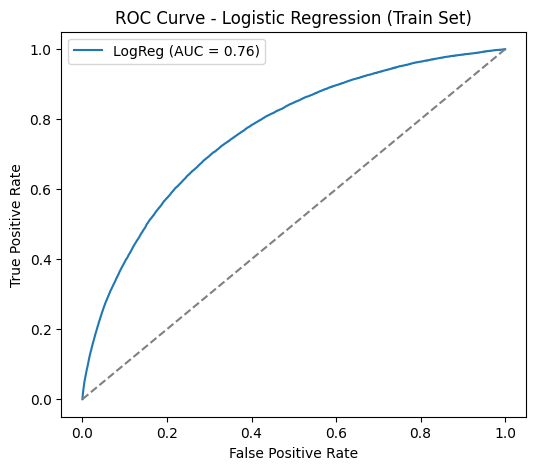

Submission saved! (TARGET dalam bentuk 0/1)


In [12]:
y_pred_train = model.predict(X_scaled)

print("\n===== Evaluation Metrics (Train Set) =====")
print("Accuracy:", accuracy_score(y, y_pred_train))
print("\nClassification Report:\n", classification_report(y, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_train))

roc_auc = roc_auc_score(y, model.predict_proba(X_scaled)[:,1])
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y, model.predict_proba(X_scaled)[:,1])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Train Set)")
plt.legend()
plt.show()


# Thresholding jadi 0/1 untuk submission
threshold = 0.08
preds_binary = (preds_proba >= threshold).astype(int)


# Export Submission
submission = pd.DataFrame({"SK_ID_CURR": test["SK_ID_CURR"], "TARGET": preds_binary})
submission.to_csv("submission_LR_fixed.csv", index=False)
print("Submission saved! (TARGET dalam bentuk 0/1)")
